Deep Learning
=============

Assignment 1
------------

The objective of this assignment is to learn about simple data curation practices, and familiarize you with some of the data we'll be reusing later.

This notebook uses the [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) dataset to be used with python experiments. This dataset is designed to look like the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset, while looking a little more like real data: it's a harder task, and the data is a lot less 'clean' than MNIST.

In [19]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
import matplotlib.pyplot as plt
import numpy as np
import os
import tarfile
import urllib
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
import cPickle as pickle

First, we'll download the dataset to our local machine. The data consists of characters rendered in a variety of fonts on a 28x28 image. The labels are limited to 'A' through 'J' (10 classes). The training set has about 500k and the testset 19000 labelled examples. Given these sizes, it should be possible to train models quickly on any machine.

In [3]:
url = 'http://yaroslavvb.com/upload/notMNIST/'

def maybe_download(filename, expected_bytes):
  """Download a file if not present, and make sure it's the right size."""
  if not os.path.exists(filename):
    filename, _ = urllib.urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print 'Found and verified', filename
  else:
    raise Exception(
      'Failed to verify' + filename + '. Can you get to it with a browser?')
  return filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Found and verified notMNIST_large.tar.gz
Found and verified notMNIST_small.tar.gz


Extract the dataset from the compressed .tar.gz file.
This should give you a set of directories, labelled A through J.

In [4]:
num_classes = 10

def extract(filename):
  tar = tarfile.open(filename)
  tar.extractall()
  tar.close()
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  data_folders = [os.path.join(root, d) for d in sorted(os.listdir(root))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_folders, len(data_folders)))
  print data_folders
  return data_folders
  
train_folders = extract(train_filename)
test_folders = extract(test_filename)

['notMNIST_large/A', 'notMNIST_large/B', 'notMNIST_large/C', 'notMNIST_large/D', 'notMNIST_large/E', 'notMNIST_large/F', 'notMNIST_large/G', 'notMNIST_large/H', 'notMNIST_large/I', 'notMNIST_large/J']
['notMNIST_small/A', 'notMNIST_small/B', 'notMNIST_small/C', 'notMNIST_small/D', 'notMNIST_small/E', 'notMNIST_small/F', 'notMNIST_small/G', 'notMNIST_small/H', 'notMNIST_small/I', 'notMNIST_small/J']


---
Problem 1
---------

Let's take a peek at some of the data to make sure it looks sensible. Each exemplar should be an image of a character A through J rendered in a different font. Display a sample of the images that we just downloaded. Hint: you can use the package IPython.display.

---

In [5]:
import random

# Get a random image from <directory> and display it
def sampleImage(directoryName):
    randomFile = random.choice(os.listdir(directoryName))
    return Image(filename=os.path.join(directoryName,randomFile))

# Sample a letter from each directory in the test_folders
[display(sampleImage(f)) for f in test_folders]

[None, None, None, None, None, None, None, None, None, None]

Now let's load the data in a more manageable format.

We'll convert the entire dataset into a 3D array (image index, x, y) of floating point values, normalized to have approximately zero mean and standard deviation ~0.5 to make training easier down the road. The labels will be stored into a separate array of integers 0 through 9.

A few images might not be readable, we'll just skip them.

In [6]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load(data_folders, min_num_images, max_num_images):
  dataset = np.ndarray(
    shape=(max_num_images, image_size, image_size), dtype=np.float32)
  labels = np.ndarray(shape=(max_num_images), dtype=np.int32)
  label_index = 0
  image_index = 0
  for folder in data_folders:
    print folder
    for image in os.listdir(folder):
      if image_index >= max_num_images:
        raise Exception('More images than expected: %d >= %d' % (
          num_images, max_num_images))
      image_file = os.path.join(folder, image)
      try:
        image_data = (ndimage.imread(image_file).astype(float) -
                      pixel_depth / 2) / pixel_depth
        if image_data.shape != (image_size, image_size):
          raise Exception('Unexpected image shape: %s' % str(image_data.shape))
        dataset[image_index, :, :] = image_data
        labels[image_index] = label_index
        image_index += 1
      except IOError as e:
        print 'Could not read:', image_file, ':', e, '- it\'s ok, skipping.'
    label_index += 1
  num_images = image_index
  dataset = dataset[0:num_images, :, :]
  labels = labels[0:num_images]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' % (
        num_images, min_num_images))
  print 'Full dataset tensor:', dataset.shape
  print 'Mean:', np.mean(dataset)
  print 'Standard deviation:', np.std(dataset)
  print 'Labels:', labels.shape
  return dataset, labels
train_dataset, train_labels = load(train_folders, 450000, 550000)
test_dataset, test_labels = load(test_folders, 18000, 20000)

notMNIST_large/A
Could not read: notMNIST_large/A/RnJlaWdodERpc3BCb29rSXRhbGljLnR0Zg==.png : cannot identify image file - it's ok, skipping.
Could not read: notMNIST_large/A/SG90IE11c3RhcmQgQlROIFBvc3Rlci50dGY=.png : cannot identify image file - it's ok, skipping.
Could not read: notMNIST_large/A/Um9tYW5hIEJvbGQucGZi.png : cannot identify image file - it's ok, skipping.
notMNIST_large/B
Could not read: notMNIST_large/B/TmlraXNFRi1TZW1pQm9sZEl0YWxpYy5vdGY=.png : cannot identify image file - it's ok, skipping.
notMNIST_large/C
notMNIST_large/D
Could not read: notMNIST_large/D/VHJhbnNpdCBCb2xkLnR0Zg==.png : cannot identify image file - it's ok, skipping.
notMNIST_large/E
notMNIST_large/F
notMNIST_large/G
notMNIST_large/H
notMNIST_large/I
notMNIST_large/J
Full dataset tensor: (529114, 28, 28)
Mean: -0.020222
Standard deviation: 0.142204
Labels: (529114,)
notMNIST_small/A
Could not read: notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png : cannot identify image file - it's ok

---
Problem 2
---------

Let's verify that the data still looks good. Displaying a sample of the labels and images from the ndarray. Hint: you can use matplotlib.pyplot.

---

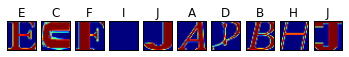

['E', 'C', 'F', 'I', 'J', 'A', 'D', 'B', 'H', 'J']


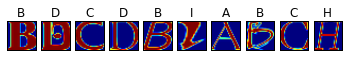

['B', 'D', 'C', 'D', 'B', 'I', 'A', 'B', 'C', 'H']


In [7]:
import random
%matplotlib inline
def showProcessedRandom(dataset,labels,n): # shows size of the sample
    indices=random.sample(range(0,labels.shape[0]),n)
    fig=plt.figure()
    for i in range(n):
        a=fig.add_subplot(1,n,i+1)
        plt.imshow(dataset[indices[i],:,:])
        a.set_title(chr(labels[indices[i]]+ord('A')))
        a.axes.get_xaxis().set_visible(False)
        a.axes.get_yaxis().set_visible(False)
    plt.show()
    print [chr(ord('A') + x) for x in labels[indices]]
    
showProcessedRandom(train_dataset,train_labels,10) 
showProcessedRandom(test_dataset,test_labels,10)

Next, we'll randomize the data. It's important to have the labels well shuffled for the training and test distributions to match.

In [8]:
np.random.seed(133)
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)

---
Problem 3
---------
Convince yourself that the data is still good after shuffling!

---

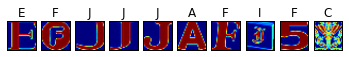

['E', 'F', 'J', 'J', 'J', 'A', 'F', 'I', 'F', 'C']


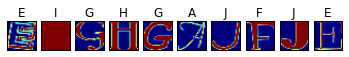

['E', 'I', 'G', 'H', 'G', 'A', 'J', 'F', 'J', 'E']


In [9]:
import random
%matplotlib inline
def showProcessedRandom(dataset,labels,n): # shows size of the sample
    indices=random.sample(range(0,labels.shape[0]),n)
    fig=plt.figure()
    for i in range(n):
        a=fig.add_subplot(1,n,i+1)
        plt.imshow(dataset[indices[i],:,:])
        a.set_title(chr(labels[indices[i]]+ord('A')))
        a.axes.get_xaxis().set_visible(False)
        a.axes.get_yaxis().set_visible(False)
    plt.show()
    print [chr(ord('A') + x) for x in labels[indices]]
    
showProcessedRandom(train_dataset,train_labels,10) 
showProcessedRandom(test_dataset,test_labels,10)

---
Problem 4
---------
Another check: we expect the data to be balanced across classes. Verify that.

---

(array([ 1872.,  1873.,  1873.,  1873.,  1873.,  1872.,  1872.,  1872.,
         1872.,  1872.]),
 array([ 0. ,  0.9,  1.8,  2.7,  3.6,  4.5,  5.4,  6.3,  7.2,  8.1,  9. ]),
 <a list of 10 Patch objects>)

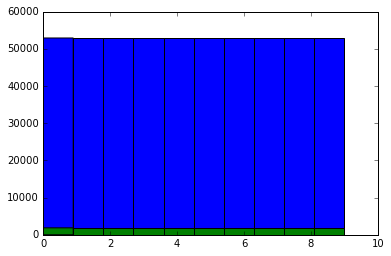

In [10]:
plt.hist(train_labels, 10)
plt.hist(test_labels, 10)

Prune the training data as needed. Depending on your computer setup, you might not be able to fit it all in memory, and you can tune train_size as needed.

Also create a validation dataset for hyperparameter tuning.

In [11]:
train_size = 400000
valid_size = 30000

valid_dataset = train_dataset[:valid_size,:,:]
valid_labels = train_labels[:valid_size]
train_dataset = train_dataset[valid_size:valid_size+train_size,:,:]
train_labels = train_labels[valid_size:valid_size+train_size]
print 'Training', train_dataset.shape, train_labels.shape
print 'Validation', valid_dataset.shape, valid_labels.shape

Training (400000, 28, 28) (400000,)
Validation (30000, 28, 28) (30000,)


Finally, let's save the data for later reuse:

In [12]:
pickle_file = 'notMNIST.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print 'Unable to save data to', pickle_file, ':', e
  raise

In [13]:
statinfo = os.stat(pickle_file)
print 'Compressed pickle size:', statinfo.st_size

Compressed pickle size: 1408993801


---
Problem 5
---------

By construction, this dataset might contain a lot of overlapping samples, including training data that's also contained in the validation and test set! Overlap between training and test can skew the results if you expect to use your model in an environment where there is never an overlap, but are actually ok if you expect to see training samples recur when you use it.
Measure how much overlap there is between training, validation and test samples.
Optional questions:
- What about near duplicates between datasets? (images that are almost identical)
- Create a sanitized validation and test set, and compare your accuracy on those in subsequent assignments.
---

Train duplicates count: 41629
Test duplicates count: 4092
Total duplicates count: 45721
(400000, 28, 28)
(325553, 28, 28)
400000
325553
(18724, 28, 28)
(14632, 28, 28)
18724
14632


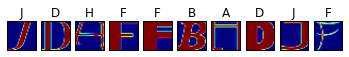

['J', 'D', 'H', 'F', 'F', 'B', 'A', 'D', 'J', 'F']


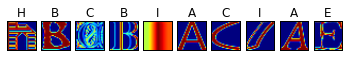

['H', 'B', 'C', 'B', 'I', 'A', 'C', 'I', 'A', 'E']


In [14]:
def get_dup_table(train_dataset, test_dataset):
    train_dataset.flags.writeable=False
    test_dataset.flags.writeable=False
    train_duplicates_count=0
    test_duplicates_count=0
    image_hashes={}
    dup_table={}

    for idx,img in enumerate(train_dataset):
        h = hash(img.data)
        if h in image_hashes and (image_hashes[h].data == img.data):
            #print 'Duplicate image: %d matches %d' % (idx, dup_table[h])
            train_duplicates_count+=1
            dup_table[h] = img
        image_hashes[h]=img

    print 'Train duplicates count: %d' % (train_duplicates_count)


    for idx,img in enumerate(test_dataset):
        h = hash(img.data)
        if h in image_hashes and (image_hashes[h].data == img.data):
            #print 'Test image %d is in the training set' % idx
            test_duplicates_count+=1
            dup_table[h] = img

    print 'Test duplicates count: %d' % (test_duplicates_count)
    print 'Total duplicates count: %d' % (train_duplicates_count + test_duplicates_count)

    return dup_table

def filter_duplicates(dup_table, dataset, data_labels):
    dataset.flags.writeable=False
    clean_set=[]
    clean_labels=[]
    count=0
    
    for idx, v in enumerate(zip(dataset, data_labels)):
        img = v[0]
        label = v[1]
        h = hash(img.data)
        if h not in dup_table:
            clean_set.extend(img)
            clean_labels.append(label)
            count+=1
            
    (samples, width, height) = dataset.shape
    clean_set = np.reshape(clean_set, (count, width, height))
    
    return (clean_set, clean_labels)

dup_table = get_dup_table(train_dataset, test_dataset)

(clean_train_dataset, clean_train_labels) = filter_duplicates(dup_table, train_dataset, train_labels)
print train_dataset.shape
print clean_train_dataset.shape
print len(train_labels)
print len(clean_train_labels)

(clean_test_dataset, clean_test_labels) = filter_duplicates(dup_table, test_dataset, test_labels)
print test_dataset.shape
print clean_test_dataset.shape
print len(test_labels)
print len(clean_test_labels)

showProcessedRandom(train_dataset,train_labels,10) 
showProcessedRandom(test_dataset,test_labels,10)

---
Problem 6
---------

Let's get an idea of what an off-the-shelf classifier can give you on this data. It's always good to check that there is something to learn, and that it's a problem that is not so trivial that a canned solution solves it.

Train a simple model on this data using 50, 100, 1000 and 5000 training samples. Hint: you can use the LogisticRegression model from sklearn.linear_model.

Optional question: train an off-the-shelf model on all the data!

---

In [30]:
def train_and_print(train_dataset, test_dataset, train_labels, test_labels, num_samples, n_classes=10):
        
        (samples, width, height) = train_dataset.shape
        X = np.reshape(train_dataset,(samples, width*height))[0:num_samples]
        y = train_labels[0:num_samples]

        print X.shape
 
        lr = LogisticRegression()
        if samples < 5000:
            lr.fit(X, y)
        else:
            lr.fit(X[:10], y[:10])
            print "Logistic Regression will be too slow, skipping training!"

        (valid_samples, valid_width, valid_height) = valid_dataset.shape
        
        X_valid = np.reshape(valid_dataset, (valid_samples, valid_width*valid_height))
        y_valid = valid_labels
        lr_score = lr.score(X_valid, y_valid)
        print "LR score: %.2f" % lr_score
        
        sgd = SGDClassifier(loss="log", learning_rate="optimal", average=100, alpha=0.00001)
        sgd.fit(X, y)
        
        X_valid = np.reshape(valid_dataset, (valid_samples, valid_width*valid_height))
        y_valid = valid_labels
        sgd_score = sgd.score(X_valid, y_valid)
        print "SGD score: %.2f" % sgd_score
        
        picked_model_string = ("Logistic Regression", "SGD")[sgd_score > lr_score]
        picked_model = (lr, sgd)[sgd_score > lr_score]
        
        print "Picking model: %s" % picked_model_string
        
        (samples, width, height) = test_dataset.shape
        X_test = np.reshape(test_dataset, (samples, width*height))
        y_test = test_labels
        print "Final test score: %.2f" % picked_model.score(X_test, y_test)

'''
train_and_print(train_dataset, test_dataset, train_labels, test_labels, 50)
train_and_print(clean_train_dataset, clean_test_dataset, clean_train_labels, clean_test_labels, 50)
train_and_print(train_dataset, test_dataset, train_labels, test_labels, 100)
train_and_print(clean_train_dataset, clean_test_dataset, clean_train_labels, clean_test_labels, 100)
train_and_print(train_dataset, test_dataset, train_labels, test_labels, 1000)
train_and_print(clean_train_dataset, clean_test_dataset, clean_train_labels, clean_test_labels, 1000)
train_and_print(train_dataset, test_dataset, train_labels, test_labels, 10000)
train_and_print(clean_train_dataset, clean_test_dataset, clean_train_labels, clean_test_labels, 10000)
'''
train_and_print(train_dataset, test_dataset, train_labels, test_labels, 20000)
train_and_print(clean_train_dataset, clean_test_dataset, clean_train_labels, clean_test_labels, 20000)
train_and_print(train_dataset, test_dataset, train_labels, test_labels, 40000)
train_and_print(clean_train_dataset, clean_test_dataset, clean_train_labels, clean_test_labels, 40000)
train_and_print(train_dataset, test_dataset, train_labels, test_labels, 80000)
train_and_print(clean_train_dataset, clean_test_dataset, clean_train_labels, clean_test_labels, 80000)
train_and_print(train_dataset, test_dataset, train_labels, test_labels, 120000)
train_and_print(clean_train_dataset, clean_test_dataset, clean_train_labels, clean_test_labels, 120000)
#train_and_print(train_dataset, test_dataset, 5000)
#train_and_print(train_dataset, test_dataset, 50000)
#train_and_print(train_dataset, test_dataset, 100000)
#train_and_print(train_dataset, test_dataset, 200000)
#train_and_print(train_dataset, test_dataset, 400000)

(20000, 784)
Logistic Regression will be too slow, skipping training!
LR score: 0.31
SGD score: 0.82
Picking model: SGD
Final test score: 0.89
(20000, 784)
Logistic Regression will be too slow, skipping training!
LR score: 0.35
SGD score: 0.82
Picking model: SGD
Final test score: 0.87
(40000, 784)
Logistic Regression will be too slow, skipping training!
LR score: 0.31
SGD score: 0.82
Picking model: SGD
Final test score: 0.89
(40000, 784)
Logistic Regression will be too slow, skipping training!
LR score: 0.35
SGD score: 0.82
Picking model: SGD
Final test score: 0.87
(80000, 784)
Logistic Regression will be too slow, skipping training!
LR score: 0.31
SGD score: 0.83
Picking model: SGD
Final test score: 0.89
(80000, 784)
Logistic Regression will be too slow, skipping training!
LR score: 0.35
SGD score: 0.83
Picking model: SGD
Final test score: 0.87
(120000, 784)
Logistic Regression will be too slow, skipping training!
LR score: 0.31
SGD score: 0.83
Picking model: SGD
Final test score: 0.8